SVD

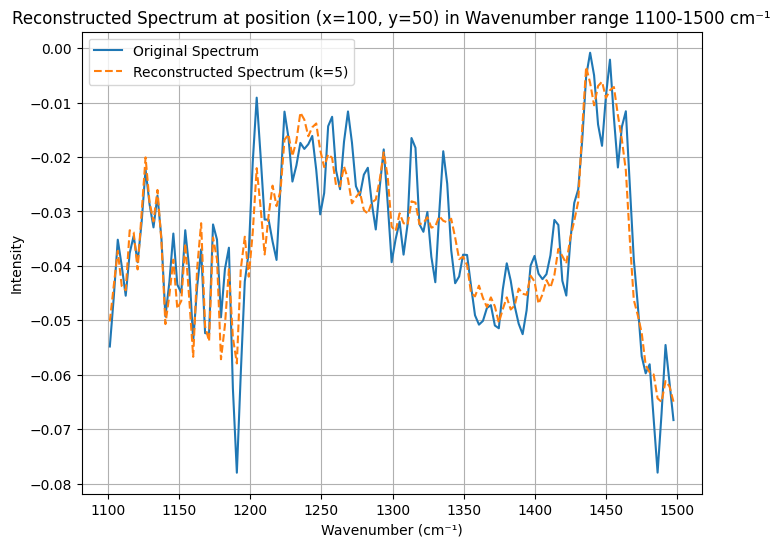

In [4]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from my_func.Read_ibw import read_ibw


# SVDを特定の波数範囲に対して行う関数
def apply_svd_in_wavenumber_range(data, wavelengths, min_wavenumber, max_wavenumber, k):
    """
    指定された波数範囲内のデータに対してSVDを適用し、ノイズ除去を行う
    data: 4次元データ (x, y, z, wavelength)
    wavelengths: 波数の配列
    min_wavenumber: 波数範囲の最小値
    max_wavenumber: 波数範囲の最大値
    k: 上位k個の特異値を保持
    """
    # 1. 指定した波数範囲に対応するインデックスを取得
    range_mask = (wavelengths >= min_wavenumber) & (wavelengths <= max_wavenumber)
    wavelengths_in_range = wavelengths[range_mask]
    data_in_range = data[:, :, 0, range_mask]  # 指定範囲内のデータを抽出 (x, y, wavelength)

    # 2. 波数範囲内の全体データ (151x201x波数範囲) に対してSVDを実行
    reshaped_data = data_in_range.reshape(-1, data_in_range.shape[2])  # (x*y, wavelength) の2次元に変換
    U, S, Vt = svd(reshaped_data, full_matrices=False)

    # # 特異値のプロット
    # plt.figure(figsize=(8, 6))
    # plt.plot(S, marker='o')
    # plt.xlabel('Index')
    # plt.ylabel('Singular Value')
    # plt.title(f'Singular Values in Wavenumber Range {min_wavenumber}-{max_wavenumber} cm⁻¹')
    # plt.grid(True)
    # plt.show()

    # 3. 上位k個の特異値を使ってデータを再構築
    S_k = np.zeros_like(S)
    S_k[:k] = S[:k]
    S_k_matrix = np.diag(S_k)

    # 再構築
    reconstructed_data = np.dot(U, np.dot(S_k_matrix, Vt))

    # 再構築されたデータを元の形に戻す
    reconstructed_data = reconstructed_data.reshape(data_in_range.shape)

    return reconstructed_data, wavelengths_in_range

data = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_imchi3_dataOrig.ibw')
# 波長軸を最後の次元に移動
data = np.moveaxis(data, 0, -1)  # 新しい形状: (151, 201, 1, 1148)

wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')

# 波数範囲を指定
min_wavenumber = 1100
max_wavenumber = 1500

# 上位特異値の数を指定
k = 20

# 関数を呼び出し、指定範囲のデータに対してSVDを適用
reconstructed_data, wavelengths_in_range = apply_svd_in_wavenumber_range(data, wavelengths, min_wavenumber, max_wavenumber, k)

# 元のデータと再構築されたデータの比較 (例えばx=100, y=50の位置で)
x, y = 100, 50
original_spectrum = data[x, y, 0, (wavelengths >= min_wavenumber) & (wavelengths <= max_wavenumber)]
reconstructed_spectrum = reconstructed_data[x, y, :]

# プロット
plt.figure(figsize=(8, 6))
plt.plot(wavelengths_in_range, original_spectrum, label='Original Spectrum')
plt.plot(wavelengths_in_range, reconstructed_spectrum, label='Reconstructed Spectrum (k=5)', linestyle='--')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.title(f'Reconstructed Spectrum at position (x={x}, y={y}) in Wavenumber range {min_wavenumber}-{max_wavenumber} cm⁻¹')
plt.legend()
plt.grid(True)
plt.show()


silent regionをもとにベイズ推定

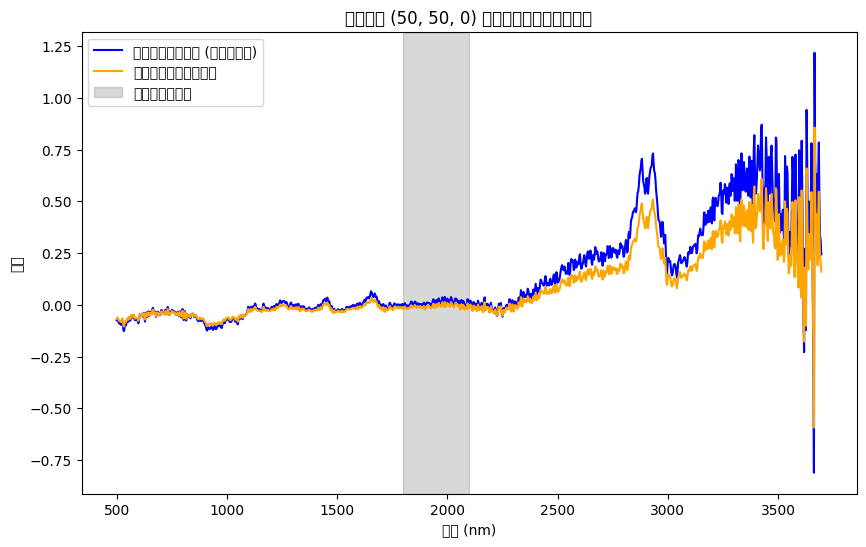

In [13]:
import numpy as np
import matplotlib.pyplot as plt


# データの読み込み
wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')
data = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_imchi3_dataOrig.ibw')
data = np.moveaxis(data, 0, -1)  # 新しい形状: (151, 201, 1, 1148)

# サイレント領域を定義
silent_region_start = 1800
silent_region_end = 2100

# サイレント領域の波長成分をマスクする
silent_mask = (wavelengths >= silent_region_start) & (wavelengths <= silent_region_end)

# サイレント領域のデータを抽出（4次元目が波長成分に対応する）
silent_region_data = data[:, :, :, silent_mask]

# サイレント領域のノイズの平均と分散を計算
noise_mean_prior = np.mean(silent_region_data)
noise_var_prior = np.var(silent_region_data)

# ベイズ推定によるノイズ除去関数
def bayesian_denoising(observed_data, prior_mean, prior_var, likelihood_var):
    """
    ベイズ推定を使ってノイズ除去を行う関数
    :param observed_data: 観測データ（ノイズを含む）
    :param prior_mean: 事前分布の平均
    :param prior_var: 事前分布の分散
    :param likelihood_var: 尤度関数の分散（観測データのノイズの大きさ）
    :return: ノイズ除去後の推定値
    """
    posterior_mean = (likelihood_var * prior_mean + prior_var * observed_data) / (prior_var + likelihood_var)
    posterior_var = (prior_var * likelihood_var) / (prior_var + likelihood_var)
    return posterior_mean, posterior_var

# 事前分布のパラメータ
prior_mean = noise_mean_prior  # サイレント領域の平均
prior_var = noise_var_prior  # サイレント領域の分散

# 尤度関数の分散（観測データのノイズレベル）
likelihood_var = 0.003  # 観測データのノイズの大きさ（データの性質により調整可能）

# ベイズ推定に基づくノイズ除去
denoised_data = np.zeros_like(data)
x_size, y_size, z_size, wavelength_size = data.shape

for i in range(x_size):
    for j in range(y_size):
        for k in range(z_size):
            denoised_data[i, j, k, :], _ = bayesian_denoising(data[i, j, k, :], prior_mean, prior_var, likelihood_var)

# データの比較のために、特定のピクセルのスペクトルをプロット
pixel_x, pixel_y, pixel_z = 50, 50, 0  # 任意のピクセル座標

plt.figure(figsize=(10, 6))

# 元データのプロット
plt.plot(wavelengths, data[pixel_x, pixel_y, pixel_z, :], label="オリジナルデータ (ノイズ含む)", color='blue')

# ベイズ推定後のデータをプロット
plt.plot(wavelengths, denoised_data[pixel_x, pixel_y, pixel_z, :], label="ベイズ推定後のデータ", color='orange')

# サイレント領域の視覚化
plt.axvspan(silent_region_start, silent_region_end, color='gray', alpha=0.3, label="サイレント領域")

plt.xlabel("波長 (nm)")
plt.ylabel("強度")
plt.legend()
plt.title(f"ピクセル ({pixel_x}, {pixel_y}, {pixel_z}) のスペクトルデータ比較")
plt.show()
